In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

In [2]:
filepath = r"C:\Users\user\Projetos\densities4risk\data\processed\database.parquet"
df = pd.read_parquet(filepath)

In [3]:
df.ticker.unique()

array(['AAVE-USD', 'AAVE_USD', 'ADA-USD', 'ADA_USD', 'AGRO3SA', 'ARB-USD',
       'ARB', 'ARB_USD', 'AVAX-USD', 'AVAX_USD', 'BCH-USD', 'BCH',
       'BCH_USD', 'BEEF3SA', 'BNB-USD', 'BNB_USD', 'BOVA11SA', 'BRFS3SA',
       'BTC-USD', 'BTC', 'BTC_USD', 'BVSP', 'CRO-USD', 'CRO_USD',
       'CSNA3SA', 'DAI-USD', 'DAI_USD', 'DOGE-USD', 'DOGE_USD', 'DOT-USD',
       'DOT_USD', 'ES', 'ETH-USD', 'ETH', 'ETH_USD', 'GGBR4SA', 'GSPC',
       'HBAR-USD', 'HBAR_USD', 'IDIVSA', 'IFIXSA', 'JBSS3SA', 'KLBN11SA',
       'LINK-USD', 'LINK', 'LINK_USD', 'LTC-USD', 'LTC', 'LTC_USD',
       'PETR3SA', 'PETR4SA', 'RAIZ4SA', 'SHIB-USD', 'SHIB_USD', 'SMLLSA',
       'SOL-USD', 'SOL', 'SOL_USD', 'SUI', 'SUZB3SA', 'TON-USD',
       'TON_USD', 'TRX-USD', 'TRX', 'TRX_USD', 'USDC-USD', 'USDC_USD',
       'USDT-USD', 'USDT_USD', 'VALE3SA', 'XLM-USD', 'XLM_USD', 'XMR-USD',
       'XMR_USD', 'XRP-USD', 'XRP_USD'], dtype=object)

In [4]:
TICKER = 'BVSP'

In [5]:
df_bvsp = df[df["ticker"]==TICKER].loc[:,["datetime", "open", "high", "low", "close"]].dropna().drop_duplicates()
df_bvsp.set_index("datetime", inplace=True)

In [6]:
df_bvsp.shape

(9951, 4)

In [7]:
df_bvsp.head(10)

,open,high,low,close
datetime,,,,
2025-05-09 10:00:00,136232.234375,136520.687500,136232.234375,136520.687500
2025-05-09 10:05:00,136504.984375,136746.140625,136323.515625,136746.140625
2025-05-09 10:10:00,136767.453125,136889.765625,136687.546875,136771.546875
2025-05-09 10:15:00,136799.515625,136862.937500,136754.781250,136862.937500
2025-05-09 10:20:00,136904.328125,136960.406250,136852.875000,136865.062500
2025-05-09 10:25:00,136841.671875,136917.109375,136743.640625,136743.640625
2025-05-09 10:30:00,136730.796875,136835.718750,136695.531250,136790.937500
2025-05-09 10:35:00,136825.265625,137004.140625,136780.921875,137004.140625
2025-05-09 10:40:00,137012.593750,137136.687500,136911.125000,137136.687500


In [8]:
df_bvsp.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

In [9]:
start_time = '10:00'
end_time = '17:00'
freq = '5T'  # 5 minutes

In [10]:
# Create a complete time index for each day
def complete_day(group):
    day = group.index[0].date()
    full_index = pd.date_range(
        f"{day} {start_time}",
        f"{day} {end_time}",
        freq=freq
    )
    return group.reindex(full_index)

In [11]:
# Apply to each day
df_complete = df_bvsp.groupby(df_bvsp.index.date, group_keys=False).apply(complete_day)

C:\Users\user\AppData\Local\Temp\ipykernel_15296\350790738.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(


In [12]:
# Reset index and rename column
df_complete = df_complete.reset_index().rename(columns={'index': 'datetime'})

In [13]:
# Added rows
df_complete.shape[0] - df_bvsp.shape[0]

164

In [14]:
df_complete.interpolate(method="linear", inplace=True)

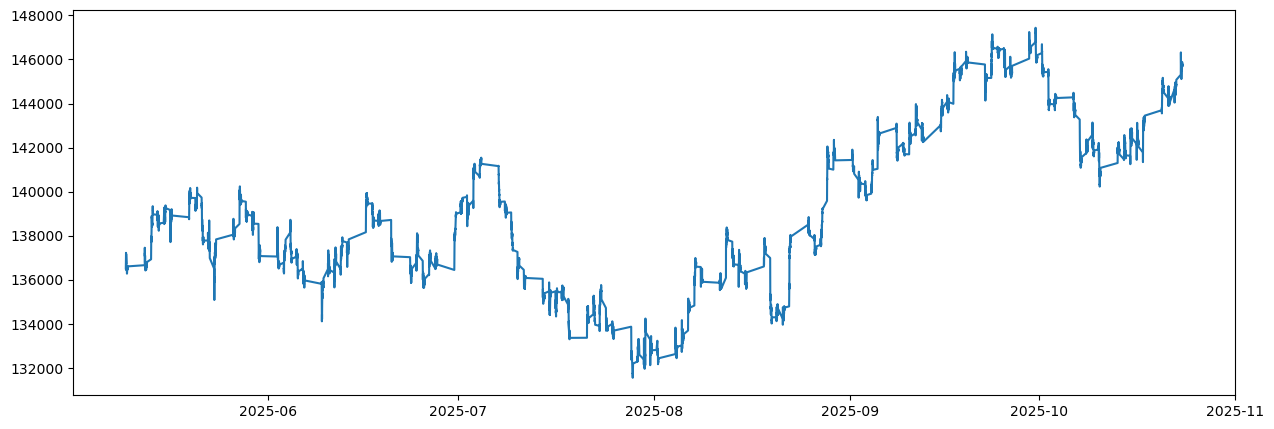

In [15]:
plt.figure(figsize=(15,5))


plt.plot(df_complete.datetime, df_complete.close)

plt.show()

In [16]:
# Retornos
df_complete["R_t"] = df_complete["close"].pct_change()
df_complete["r_t"] = np.log(df_complete["close"]) - np.log(df_complete["close"].shift(1))

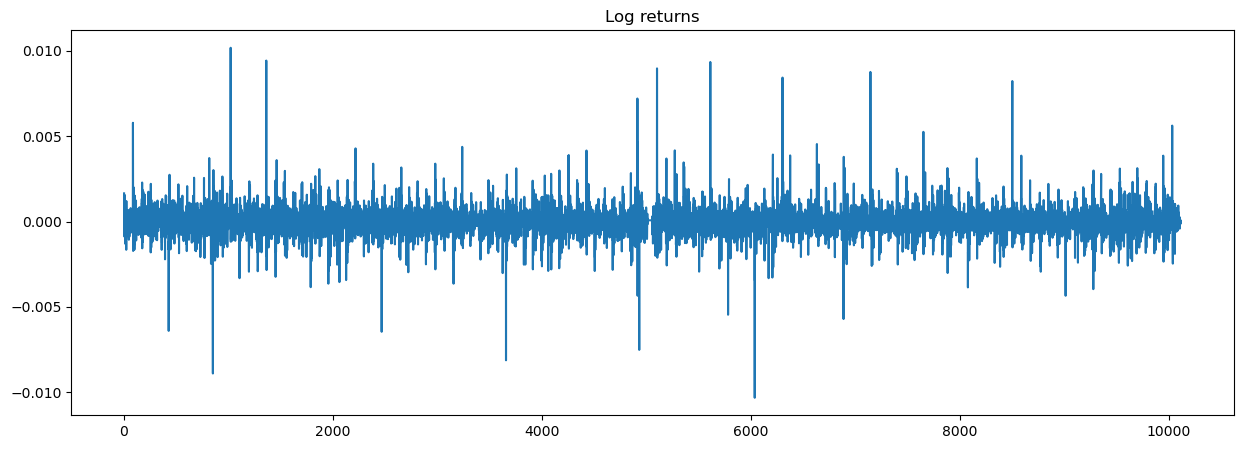

In [17]:
plt.figure(figsize=(15,5))

df_complete.r_t.plot()
plt.title("Log returns")

plt.show()

In [18]:
# Cria Series de retornos
bvsp = pd.Series(df_complete.r_t.values, index=df_complete.datetime)

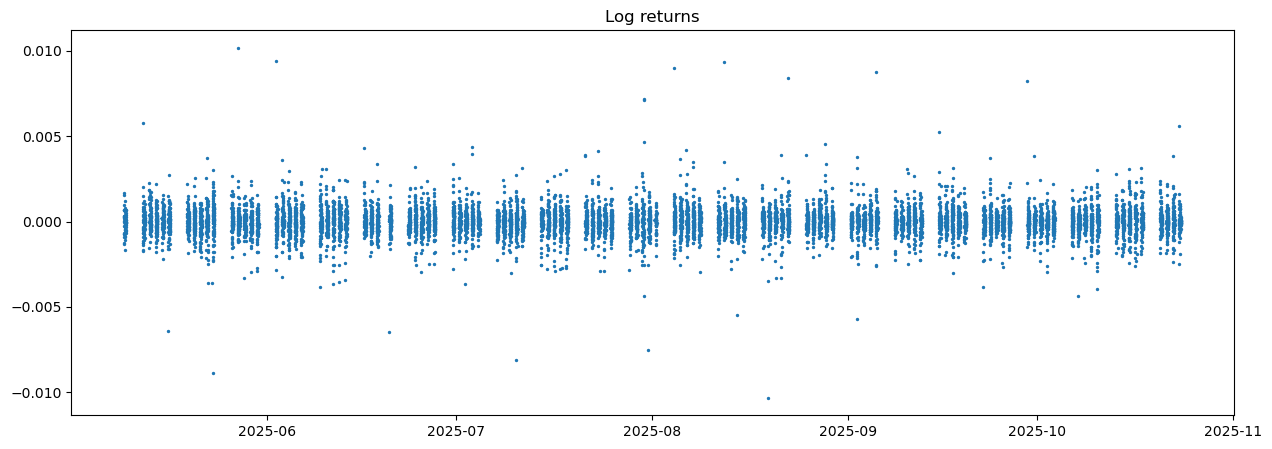

In [19]:
plt.figure(figsize=(15,5))

plt.scatter(bvsp.index, bvsp, s=2)

plt.title("Log returns")

plt.show()

In [20]:
df_complete = df_complete.dropna(subset="r_t")

[]

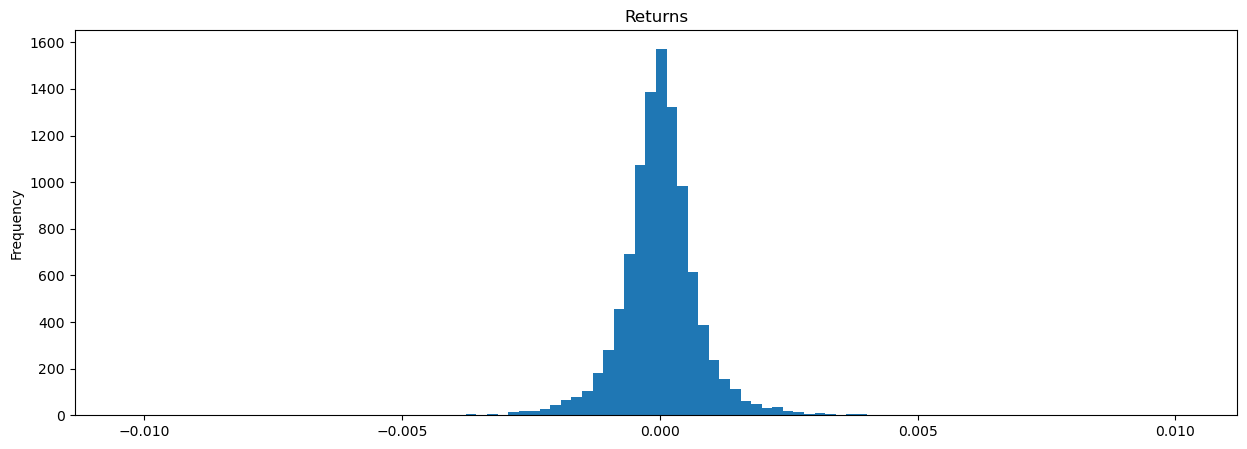

In [21]:
plt.figure(figsize=(15,5))

df_complete.r_t.plot(kind="hist", bins=100)
plt.title("Returns")

plt.plot()

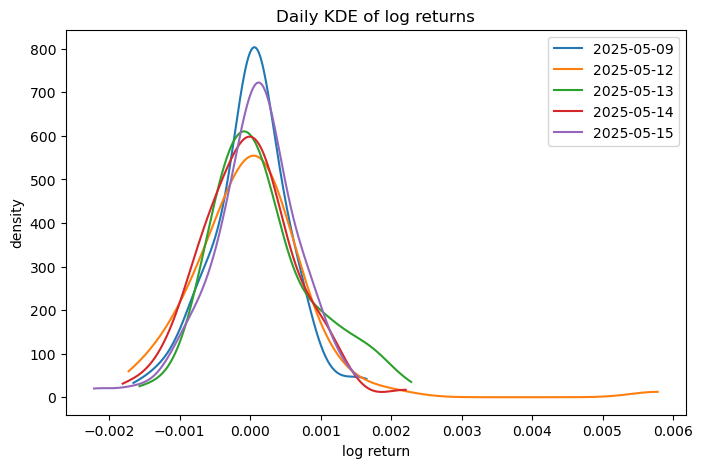

In [22]:
# Group by day
grouped = df_complete.groupby(df_complete['datetime'].dt.date)

# Compute KDE per day and store results
kde_results = {}
densities = {}

for day, group in grouped:
    data = group['r_t'].dropna()
    if len(data) > 1:  # need at least 2 points
        kde = gaussian_kde(data)
        # Evaluate on a grid for visualization
        x_grid = np.linspace(data.min(), data.max(), 200)
        y_kde = kde(x_grid)
        kde_results[day] = (x_grid, y_kde)
        densities[day]=y_kde

# Example: plot a few KDEs
plt.figure(figsize=(8,5))
for i, (day, (x, y)) in enumerate(kde_results.items()):
    if i >= 5:  # plot first 5 days
        break
    plt.plot(x, y, label=str(day))
plt.title('Daily KDE of log returns')
plt.xlabel('log return')
plt.ylabel('density')
plt.legend()
plt.show()

In [23]:
pd.DataFrame(densities)

,2025-05-09,2025-05-12,2025-05-13,2025-05-14,2025-05-15,2025-05-16,2025-05-19,2025-05-20,2025-05-21,2025-05-22,...,2025-10-10,2025-10-13,2025-10-14,2025-10-15,2025-10-16,2025-10-17,2025-10-20,2025-10-21,2025-10-22,2025-10-23
0,32.849849,59.594551,25.265025,31.115049,19.976428,11.078350,18.727138,42.137298,54.456205,11.600065,...,11.356388,28.295586,58.718794,20.703084,32.488701,44.060580,25.490300,36.896290,22.585751,16.970625
1,34.372904,64.960146,26.316286,32.634319,20.230102,11.013394,18.800171,44.897856,57.238831,11.691742,...,11.496504,29.509984,61.210022,21.933050,33.918563,46.105981,26.285969,38.616936,24.066986,17.600873
2,35.923905,70.569162,27.400516,34.184022,20.426082,10.820800,18.790084,47.754926,60.079963,11.731000,...,11.602672,30.677494,63.692822,23.234777,35.328398,48.117441,27.037272,40.343668,25.614091,18.133692
3,37.505683,76.426363,28.525599,35.770414,20.569162,10.507267,18.705107,50.708054,62.974356,11.725811,...,11.680508,31.799207,66.161404,24.614969,36.713205,50.089985,27.745080,42.078977,27.231261,18.572446
4,39.121351,82.538912,29.700687,37.401061,20.665341,10.083523,18.556081,53.756533,65.916255,11.686397,...,11.736909,32.878527,68.610209,26.080260,38.068309,52.020089,28.411852,43.826517,28.922117,18.923034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,45.268043,11.419347,44.126160,16.476605,58.232789,11.024684,19.037053,21.404834,181.430055,11.064755,...,15.907038,16.106805,53.467063,18.459397,28.675482,19.968678,40.030608,34.014037,11.890341,12.038809
196,44.647806,11.820517,41.768023,16.715497,54.897480,11.195032,19.120807,21.071470,174.371499,11.226099,...,15.346899,16.517970,52.319572,17.794388,27.069439,19.441158,38.730956,33.651536,12.184274,12.619713
197,43.914735,12.115666,39.494849,16.884123,51.710335,11.318445,19.146315,20.695476,167.386744,11.331810,...,14.807937,16.818110,51.130350,17.156596,25.552013,18.904665,37.405189,33.172648,12.398676,13.051729
198,43.065936,12.296282,37.306726,16.976836,48.660163,11.369904,19.102925,20.275486,160.484404,11.374859,...,14.282631,17.000725,49.894040,16.539903,24.118452,18.356518,36.052510,32.578083,12.529113,13.318005


In [24]:
# kde_results = {day: (x_grid, y_kde)} from previous step

# Sort days and build aligned matrices
days_sorted = sorted(kde_results.keys())

# ---- Step 1: build a common X grid (important for smooth 3D surface)
all_x = np.concatenate([kde_results[d][0] for d in days_sorted])
x_common = np.linspace(all_x.min(), all_x.max(), 200)

# ---- Step 2: evaluate each day's KDE on the common grid
Z = []
for d in days_sorted:
    kde = kde_results[d][0]
    density = kde_results[d][1]
    # Interpolate densities to common x grid
    z_interp = np.interp(x_common, kde, density)
    Z.append(z_interp)

Z = np.array(Z)
Y = np.arange(len(days_sorted))  # day index

# ---- Step 3: create 3D surface
fig = go.Figure(data=[go.Surface(
    x=x_common,   # log return values
    y=Y,          # day index
    z=Z,          # densities
    colorscale='Turbo'
)])

# ---- Step 4: layout and labels
fig.update_layout(
    title='Daily Kernel Density Estimates of Log Returns',
    scene=dict(
        xaxis_title='Log return',
        yaxis_title='Day',
        zaxis_title='Density',
        yaxis=dict(
            tickmode='array',
            tickvals=np.linspace(0, len(days_sorted)-1, 10, dtype=int),
            ticktext=[str(days_sorted[i]) for i in np.linspace(0, len(days_sorted)-1, 10, dtype=int)]
        )
    ),
    height=700
)

fig.show()

In [42]:
# kde_results = {day: (x_grid, y_kde)} from previous step

# Sort days and build aligned matrices
days_sorted = sorted(kde_results.keys())

# ---- Step 1: build a common X grid (important for smooth 3D surface)
all_x = np.concatenate([kde_results[d][0] for d in days_sorted])
x_common = np.linspace(all_x.min(), all_x.max(), 200)

# ---- Step 2: evaluate each day's KDE on the common grid
Z = []
for d in days_sorted:
    kde = kde_results[d][0]
    density = kde_results[d][1]
    # Interpolate densities to common x grid
    z_interp = np.interp(x_common, kde, density)
    Z.append(z_interp)

Z = np.array(Z)
Y = np.arange(len(days_sorted))  # day index

# ---- Step 3: create 3D surface
fig = go.Figure(data=[go.Surface(
    x=x_common,   # log return values
    y=np.arange(len(Y)),          # day index
    z=Z,          # densities
    colorscale='Turbo'
)])

# ---- Step 4: layout and labels
fig.update_layout(
    title='Daily Kernel Density Estimates of Log Returns',
    scene=dict(
        xaxis_title='Log return',
        yaxis_title='Day',
        zaxis_title='Density',
        yaxis=dict(
            tickmode='array',
            tickvals=np.linspace(0, len(days_sorted)-1, 5, dtype=int)#,
            #ticktext=[str(days_sorted[i]) for i in np.linspace(0, len(days_sorted)-1, 10, dtype=int)]
        )
    ),
    height=700
)

fig.update_layout(
    scene_camera=dict(
        eye=dict(x=0.7, y=2.0, z=0.8)  # change these values to rotate
    )
)

fig.show()
fig.write_image("../../densities4risk_doc/Figures/kde_surface.png", width=1200, height=800, scale=2)